In [49]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions
from neurolib.control.optimal_control.oc_utils.plot_oc import plot_oc_nw

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

options = {
    'node_color': 'lightgray',
    'node_size': 1000,
    'width': 2,
    'arrowstyle': '-|>',
    'arrowsize': 20,
    'font_size' : 20,
    'font_weight' : 'bold',
    }

dir = "images_5n"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
N = 5
cmats = [0, 0, 0]
points = [0, 0, 0, 0, 0]
dt = 0.1
w2_array = [0, 1]

colors = []
n = 0
for col in mcolors.TABLEAU_COLORS:
    colors.append(col)
    n += 1
    if n >= N: break

def getperiod(x, dt):
    periods = []
    for n in range(x.shape[0]):
        peaks = scipy.signal.find_peaks(x[n,:])[0]
        for p in range(2, len(peaks)-1):
            periods.append(peaks[p] - peaks[p-1])
        
        return np.mean(periods) * dt

In [112]:
with open('snyc_5n.pickle', 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

results = res_read.copy()

dict_keys(['controls', 'periods', 'timings', 'states', 'nat_periods', 'w2'])


In [113]:
skip_array = [[2,1], [2,3], [2,4]]
distsum = np.zeros((len(cmats), len(points),4))
plt_comp = False

for c in range(len(cmats)):

    for pind in range(len(points)):

        for imet in range(4):
            
            if [c, pind] in skip_array:
                continue

            print("c, pind, imet, iw = ", c, pind, imet)

            if results["states"][c][pind][imet] is None: continue

            state = results["states"][c][pind][imet]
            time = np.arange(0, 200+dt, dt)

            if plt_comp: fig, ax = plt.subplots(1,5, figsize=(20,5))
            for n in range(N):
                peaks = scipy.signal.find_peaks(-state[n,0,:], prominence=0.01)[0]
                i0_0, i0_1 = peaks[0], peaks[1]
                cycle0 = state[n,0,i0_0:i0_1]
                time0 = time[i0_0:i0_1]
                #print(peaks)

                if n == 0:
                    ii0 = 3
                    while peaks[ii0] < 800:
                        ii0 += 1
                    iii0 = peaks[ii0]
                    #print(iii0)
                else:
                    ii0 = 3
                    while np.abs(iii0 - peaks[ii0]) > results["nat_periods"][c, pind, imet]/dt:
                        ii0 += 1
                i1_0, i1_1 = peaks[ii0], peaks[ii0+1]
                cycle1 = state[n,0,i1_0:i1_1]
                time1 = time[i0_0:i0_0 + len(cycle1)]

                dtw_distance, warp_path = fastdtw(cycle0, cycle1, dist=euclidean)
                distsum[c, pind, imet] += dtw_distance

                if plt_comp:
                    ax[n].plot(time1, cycle1, color=colors[n], linestyle=":")
                    ax[n].plot(time0, cycle0, color=colors[n], label=str(n))
                    ax[n].set_title("n = " + str(n))
                    ax[n].set_ylim(0., 0.5)
                    ax[n].text(0.95, 0.95, "dist = " + str(np.around(dtw_distance,2)), horizontalalignment="right", transform=ax[n].transAxes)
            
            print("Distance sum = ", distsum[c, pind, imet])
            
            if plt_comp: plt.show()
            

c, pind, imet, iw =  0 0 0


TypeError: list indices must be integers or slices, not tuple

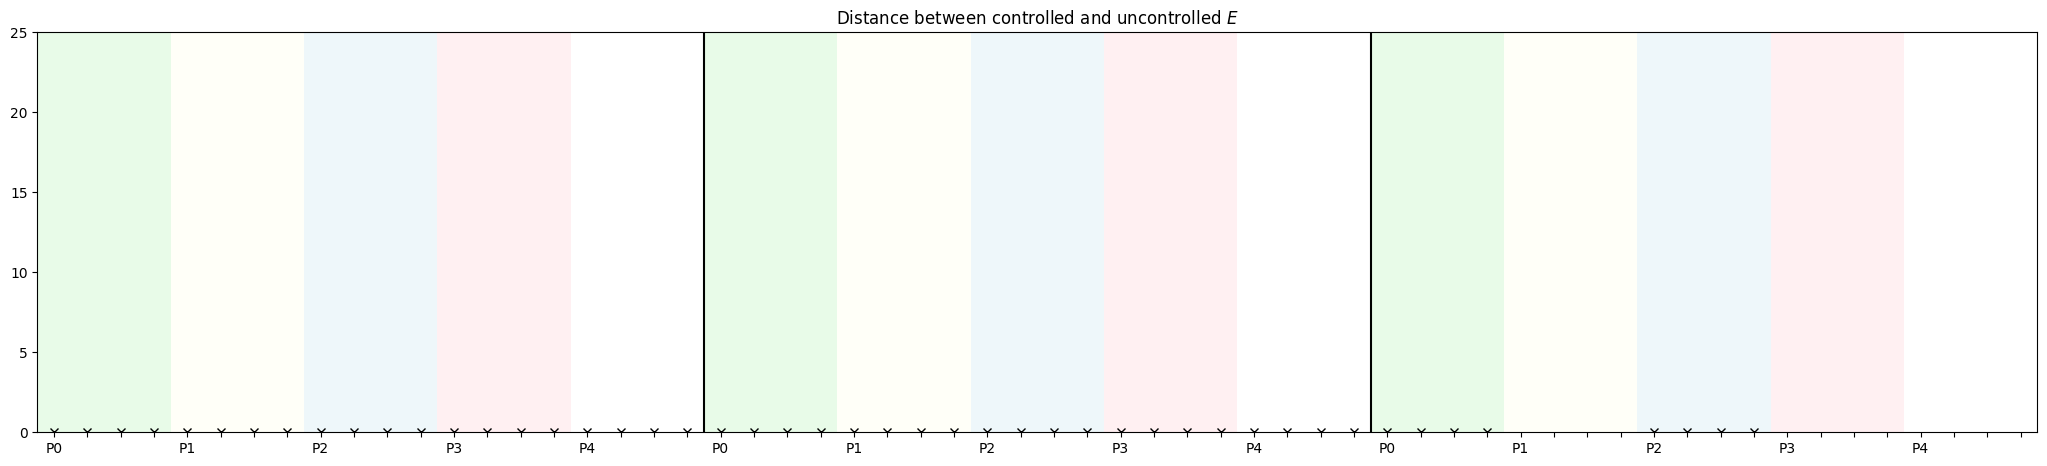

In [114]:
xl = [ "P0", "P1", "P2", "P3", "P4"]

xlabels = []
fig = plt.figure(figsize =(20, 4))
ax = fig.add_axes([0, 0, 1, 1])
xpos = 0

for c in range(len(cmats)):
    for pind in range(len(points)):
        for imet in range(4):

            if imet == 0:
                xlabels.append(xl[pind])
            else:
                xlabels.append(" ")

            if [c, pind] in skip_array:
                xpos += 1
                continue

            ax.plot(xpos+1, distsum[c, pind, imet], linestyle=None, marker="x", color="black")
            xpos += 1


y0, y1 = 0, 25
ax.set_xticks(np.arange(1., len(xlabels)+1., 1))
ax.set_xticklabels(xlabels)
ax.set_xlim(0.5, len(xlabels)+0.5)
ax.set_ylim(y0, y1)
for i in range(4):
    ax.axvspan(0.5 + i*20, 4.5 + i*20, facecolor='lightgreen', alpha=0.2)
    ax.axvspan(4.5 + i*20, 8.5 + i*20, facecolor='lightyellow', alpha=0.2)
    ax.axvspan(8.5 + i*20, 12.5 + i*20, facecolor='lightblue', alpha=0.2)
    ax.axvspan(12.5 + i*20, 16.5 + i*20, facecolor='lightpink', alpha=0.2)
ax.vlines([20.5, 40.5], y0, y1, colors=["k", "k"])
ax.set_title(r"Distance between controlled and uncontrolled $E$")
plt.show()
fig.savefig(os.path.join(dir, "dist.png"), bbox_inches='tight')